# Exploratory Data Analysis

## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## setup style

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12

## Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv('/content/drive/MyDrive/DepiProject/clean_df.csv')

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')

## overview of the system

![System Architecture](overview.png)

## Statistical Patterns

### Boxplots for Outliers

/tmp/ipython-input-3762826082.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=sensor, data=df, ax=axes[i], palette=['#1f77b4', '#d62728'])
/tmp/ipython-input-3762826082.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=sensor, data=df, ax=axes[i], palette=['#1f77b4', '#d62728'])
/tmp/ipython-input-3762826082.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=sensor, data=df, ax=axes[i], palette=['#1f77b4', '#d62728'])
/tmp/ipython-input-3762826082.py:11: FutureWarning: 

Passing `palette` with

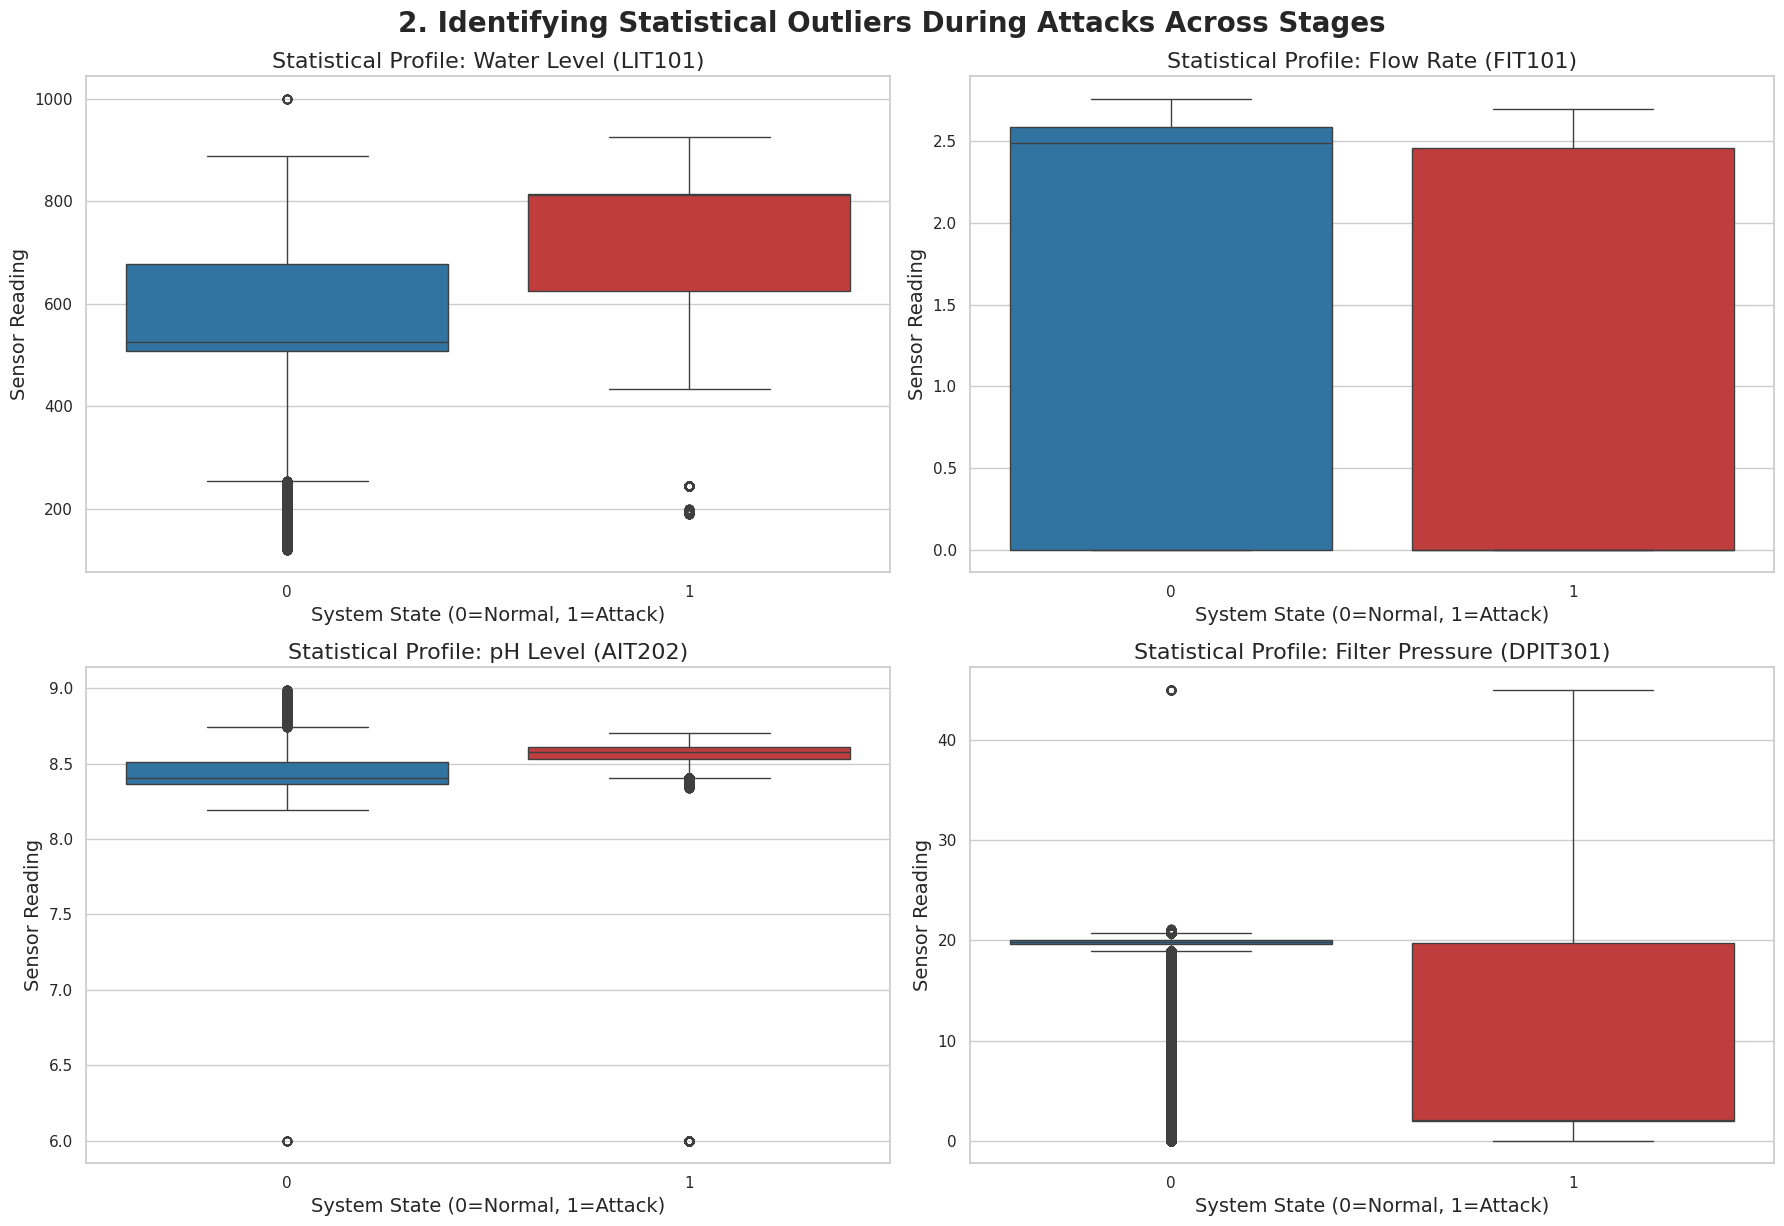

In [6]:
# Select 4 key continuous sensors from different treatment stages
key_sensors = ['LIT101', 'FIT101', 'AIT202', 'DPIT301']
titles = ['Water Level (LIT101)', 'Flow Rate (FIT101)', 'pH Level (AIT202)', 'Filter Pressure (DPIT301)']

# Create a 2x2 grid for the boxplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# Plot boxplots comparing Normal (0) vs Attack (1) states
for i, sensor in enumerate(key_sensors):
    sns.boxplot(x='label', y=sensor, data=df, ax=axes[i], palette=['#1f77b4', '#d62728'])
    axes[i].set_title(f'Statistical Profile: {titles[i]}')
    axes[i].set_xlabel('System State (0=Normal, 1=Attack)')
    axes[i].set_ylabel('Sensor Reading')

plt.tight_layout()
plt.suptitle('2. Identifying Statistical Outliers During Attacks Across Stages', y=1.02, fontsize=20, fontweight='bold')
plt.show()

df

### Logical Relationships (Cause & Effect Breakdown)

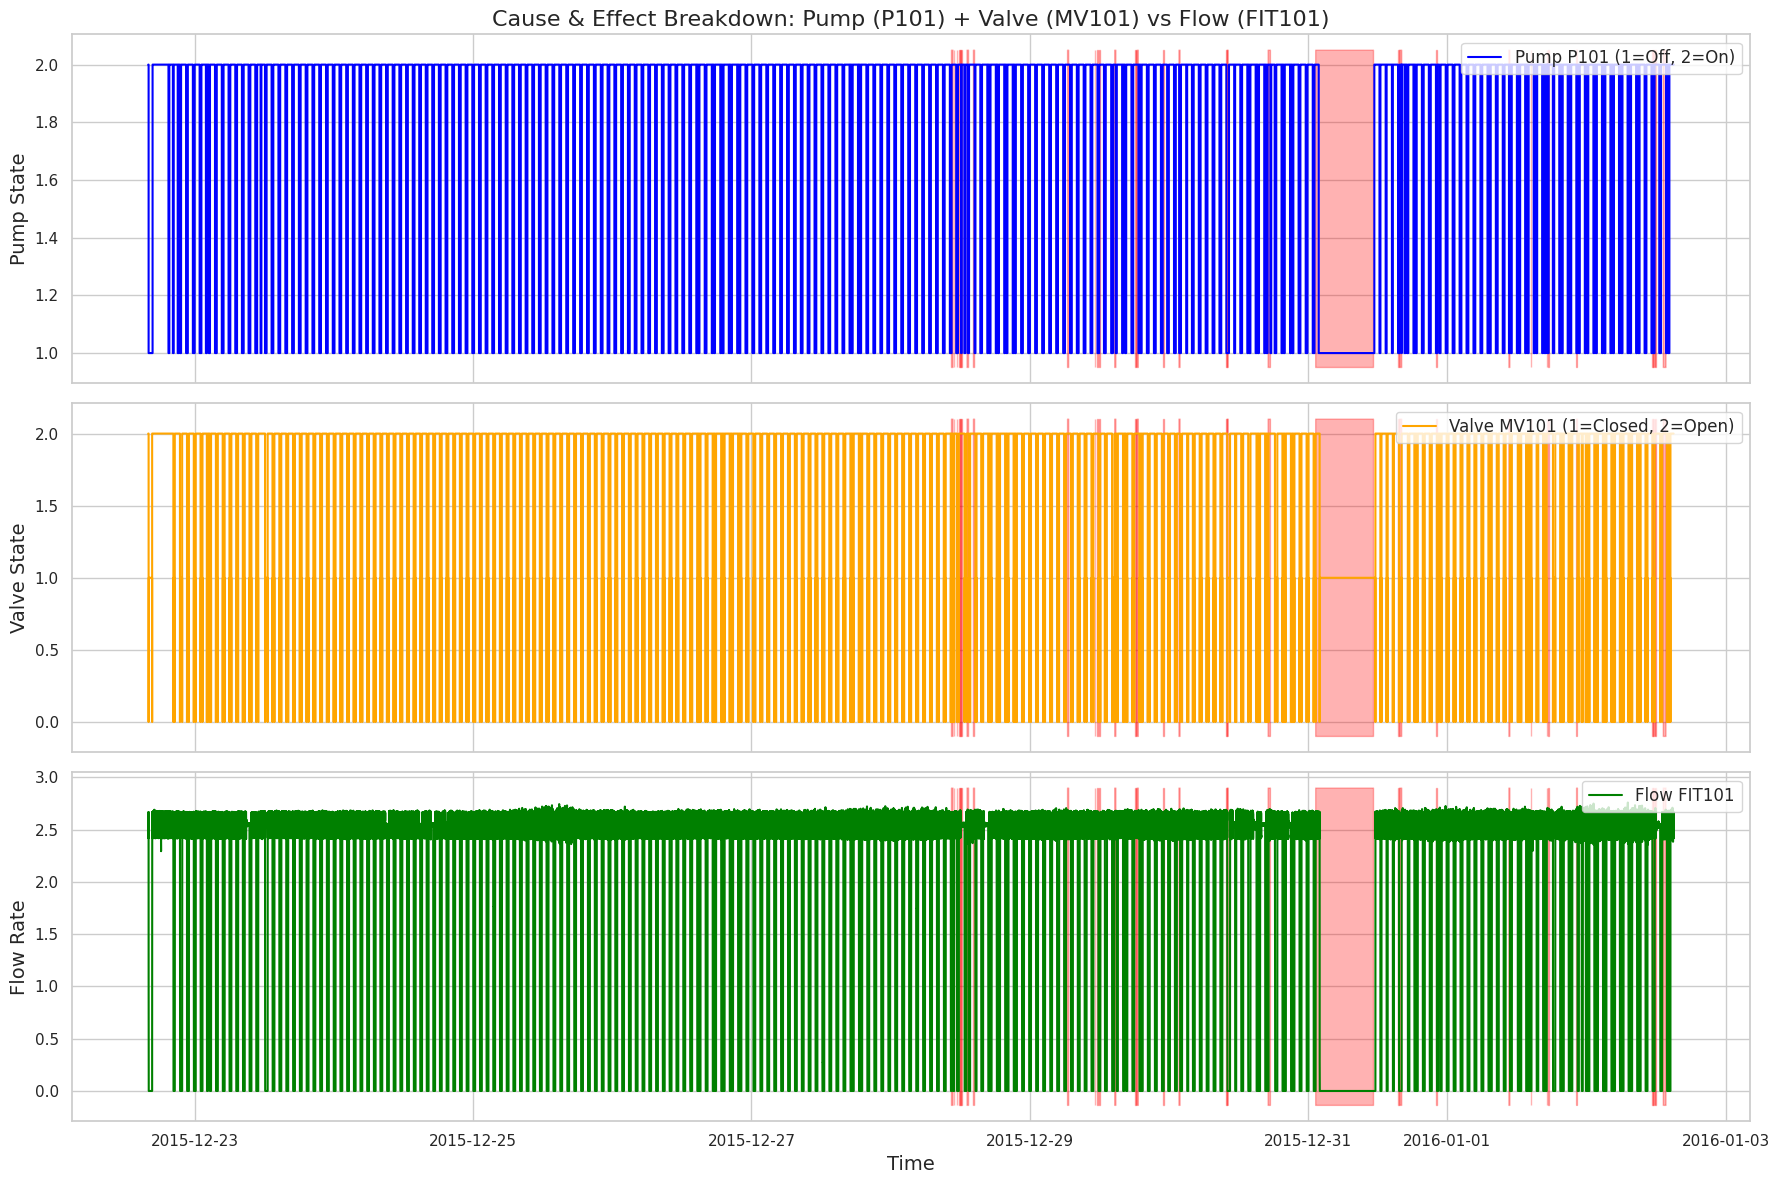

In [7]:
# Create stacked subplots sharing the same X-axis (Time)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

# Plot 1: Pump P101 State (Actuator - The Cause)
ax1.plot(df['Timestamp'], df['P101'], color='blue', label='Pump P101 (1=Off, 2=On)', drawstyle="steps-post")
ax1.set_ylabel('Pump State')
ax1.set_title('Cause & Effect Breakdown: Pump (P101) + Valve (MV101) vs Flow (FIT101)')
ax1.legend(loc='upper right')

# Plot 2: Valve MV101 State (Actuator - The Cause)
ax2.plot(df['Timestamp'], df['MV101'], color='orange', label='Valve MV101 (1=Closed, 2=Open)', drawstyle="steps-post")
ax2.set_ylabel('Valve State')
ax2.legend(loc='upper right')

# Plot 3: Flow Rate FIT101 (Sensor - The Effect)
ax3.plot(df['Timestamp'], df['FIT101'], color='green', label='Flow FIT101')
ax3.set_ylabel('Flow Rate')
ax3.set_xlabel('Time')
ax3.legend(loc='upper right')

# Highlight attack periods with a red background across all subplots
attack_mask = df['label'] == 1
for ax in [ax1, ax2, ax3]:
    ax.fill_between(df['Timestamp'], ax.get_ylim()[0], ax.get_ylim()[1], where=attack_mask, color='red', alpha=0.3, label='Attack Window')

plt.tight_layout()
plt.show()

### Mass Balance

#### Inflow vs Outflow vs Tank Level

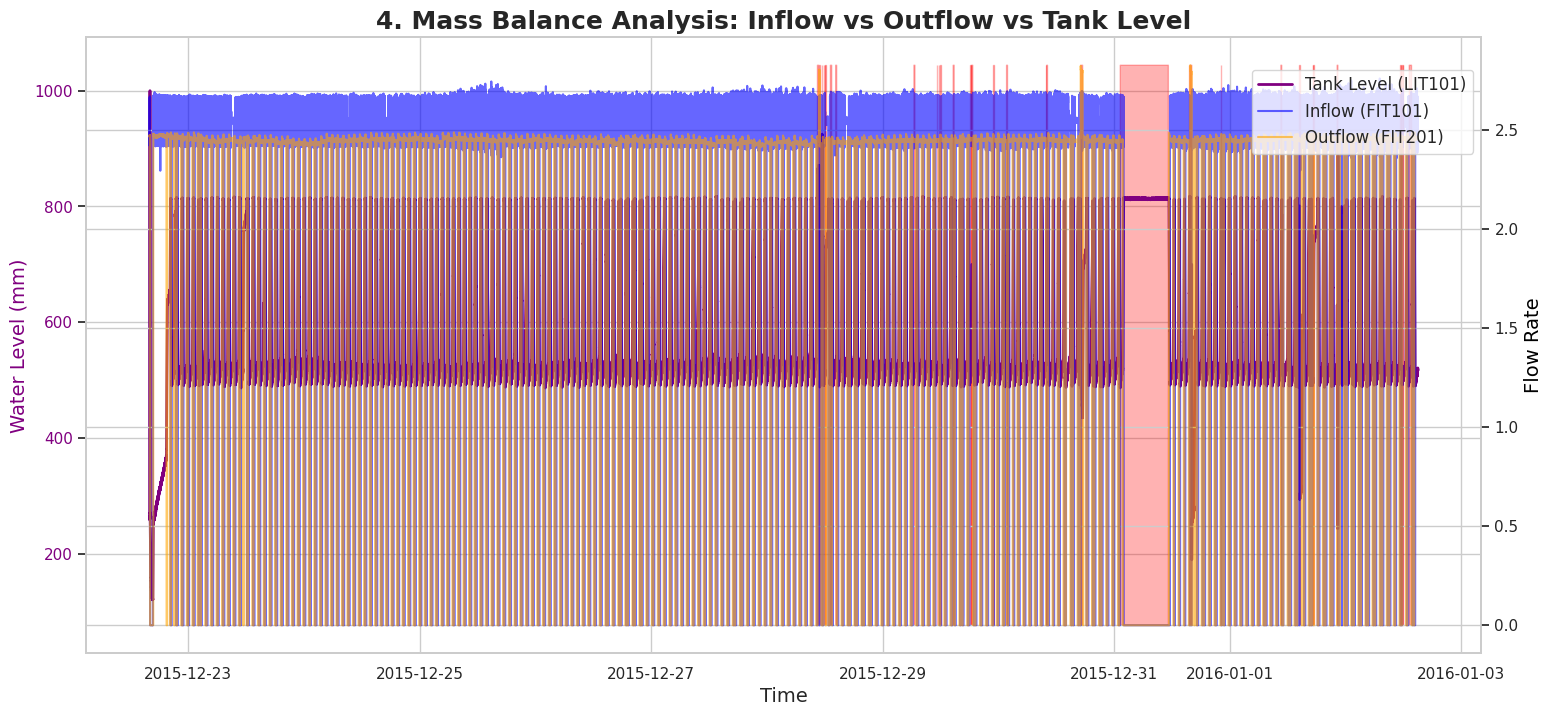

In [8]:
fig, ax1 = plt.subplots(figsize=(18, 8))

# Plot tank water level (LIT101) on the primary Y-axis
ax1.plot(df['Timestamp'], df['LIT101'], color='purple', linewidth=2, label='Tank Level (LIT101)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Water Level (mm)', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Create a secondary Y-axis for flow rates (different scale)
ax2 = ax1.twinx()
ax2.plot(df['Timestamp'], df['FIT101'], color='blue', alpha=0.6, label='Inflow (FIT101)')
ax2.plot(df['Timestamp'], df['FIT201'], color='orange', alpha=0.6, label='Outflow (FIT201)')
ax2.set_ylabel('Flow Rate', color='black')

# Highlight attack periods
ax1.fill_between(df['Timestamp'], ax1.get_ylim()[0], ax1.get_ylim()[1], where=(df['label']==1), color='red', alpha=0.3)

plt.title('4. Mass Balance Analysis: Inflow vs Outflow vs Tank Level', fontsize=18, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))
plt.show()

#### Deep-Dive Mass Balance Analysis

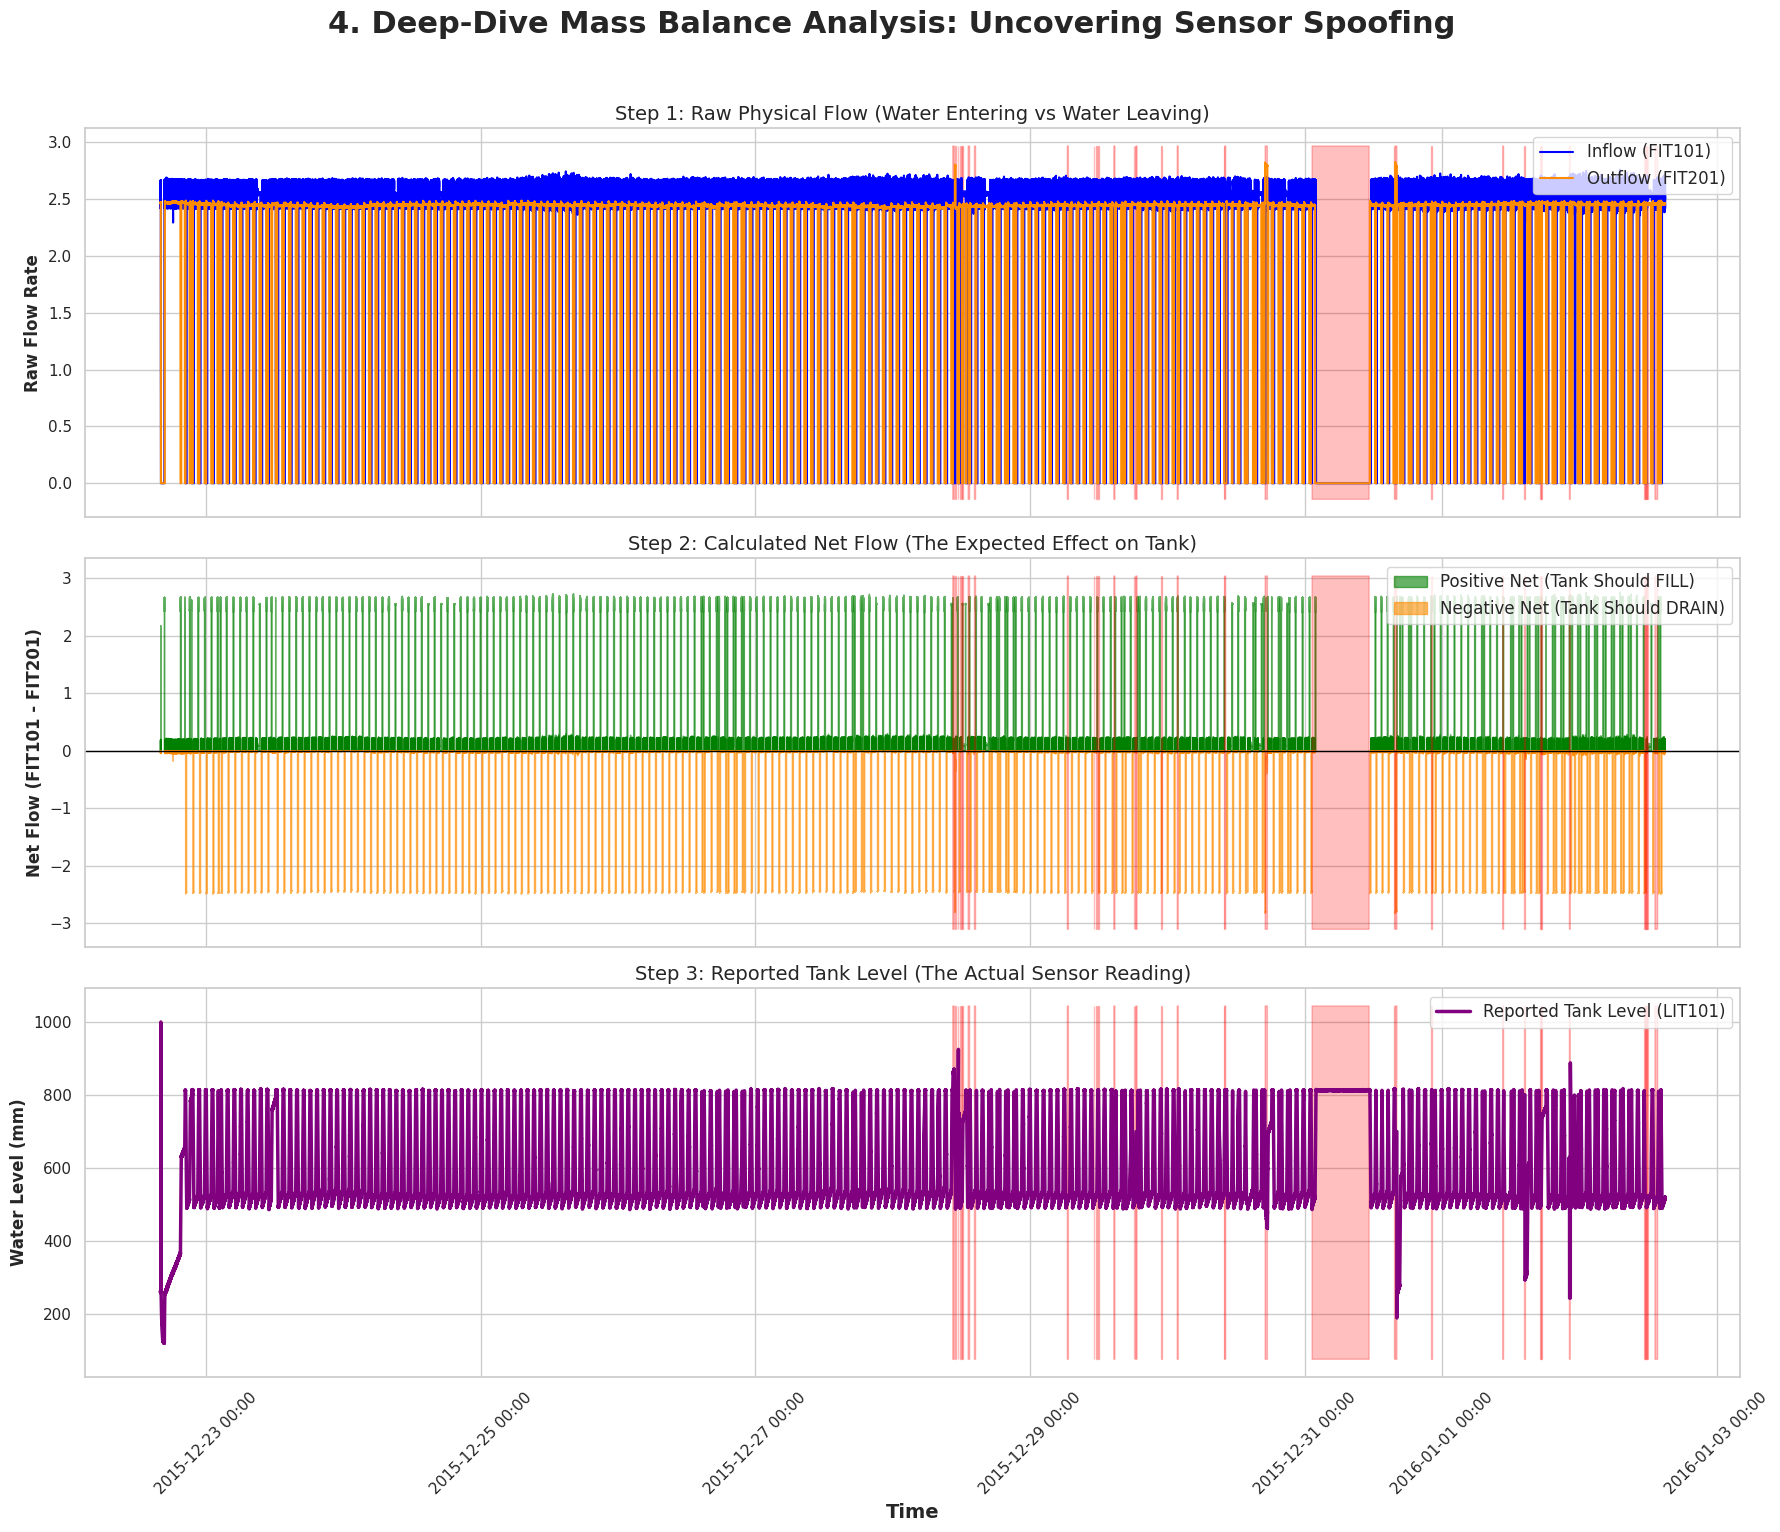

In [9]:
# 1. Calculate Net Flow (Water Entering - Water Leaving)
df['Net_Flow'] = df['FIT101'] - df['FIT201']

# 2. Create a 3-panel plot sharing the same X-axis (Time)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 15), sharex=True)

# ---------------------------------------------------------
# Top Panel: Raw Physical Flow (Inflow vs Outflow)
# ---------------------------------------------------------
# Plot Inflow (blue) and Outflow (orange)
ax1.plot(df['Timestamp'], df['FIT101'], color='blue', linewidth=1.5, label='Inflow (FIT101)')
ax1.plot(df['Timestamp'], df['FIT201'], color='darkorange', linewidth=1.5, label='Outflow (FIT201)')
ax1.set_ylabel('Raw Flow Rate', fontsize=12, fontweight='bold')
ax1.set_title('Step 1: Raw Physical Flow (Water Entering vs Water Leaving)', fontsize=14)
ax1.legend(loc='upper right')

# ---------------------------------------------------------
# Middle Panel: Calculated Net Flow (Expected effect on tank)
# ---------------------------------------------------------
# Green shading for positive net flow (filling), Orange for negative (draining)
ax2.fill_between(df['Timestamp'], 0, df['Net_Flow'], where=(df['Net_Flow'] > 0),
                 color='green', alpha=0.6, label='Positive Net (Tank Should FILL)')
ax2.fill_between(df['Timestamp'], 0, df['Net_Flow'], where=(df['Net_Flow'] < 0),
                 color='darkorange', alpha=0.6, label='Negative Net (Tank Should DRAIN)')
# Zero reference line
ax2.axhline(0, color='black', linewidth=1)
ax2.set_ylabel('Net Flow (FIT101 - FIT201)', fontsize=12, fontweight='bold')
ax2.set_title('Step 2: Calculated Net Flow (The Expected Effect on Tank)', fontsize=14)
ax2.legend(loc='upper right')

# ---------------------------------------------------------
# Bottom Panel: Reported Tank Level (Actual sensor reading)
# ---------------------------------------------------------
# Plot the reported water level (purple)
ax3.plot(df['Timestamp'], df['LIT101'], color='purple', linewidth=2.5, label='Reported Tank Level (LIT101)')
ax3.set_ylabel('Water Level (mm)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Time', fontsize=14, fontweight='bold')
ax3.set_title('Step 3: Reported Tank Level (The Actual Sensor Reading)', fontsize=14)
ax3.legend(loc='upper right')

# ---------------------------------------------------------
# Highlight Cyber Attack windows across all panels
# ---------------------------------------------------------
attack_mask = df['label'] == 1
for ax in [ax1, ax2, ax3]:
    ax.fill_between(df['Timestamp'], ax.get_ylim()[0], ax.get_ylim()[1],
                    where=attack_mask, color='red', alpha=0.25, label='Cyber Attack')

# Format the X-axis for better datetime readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

# Main title for the entire dashboard
plt.suptitle('4. Deep-Dive Mass Balance Analysis: Uncovering Sensor Spoofing', y=1.02, fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

### Full Correlation Heatmap

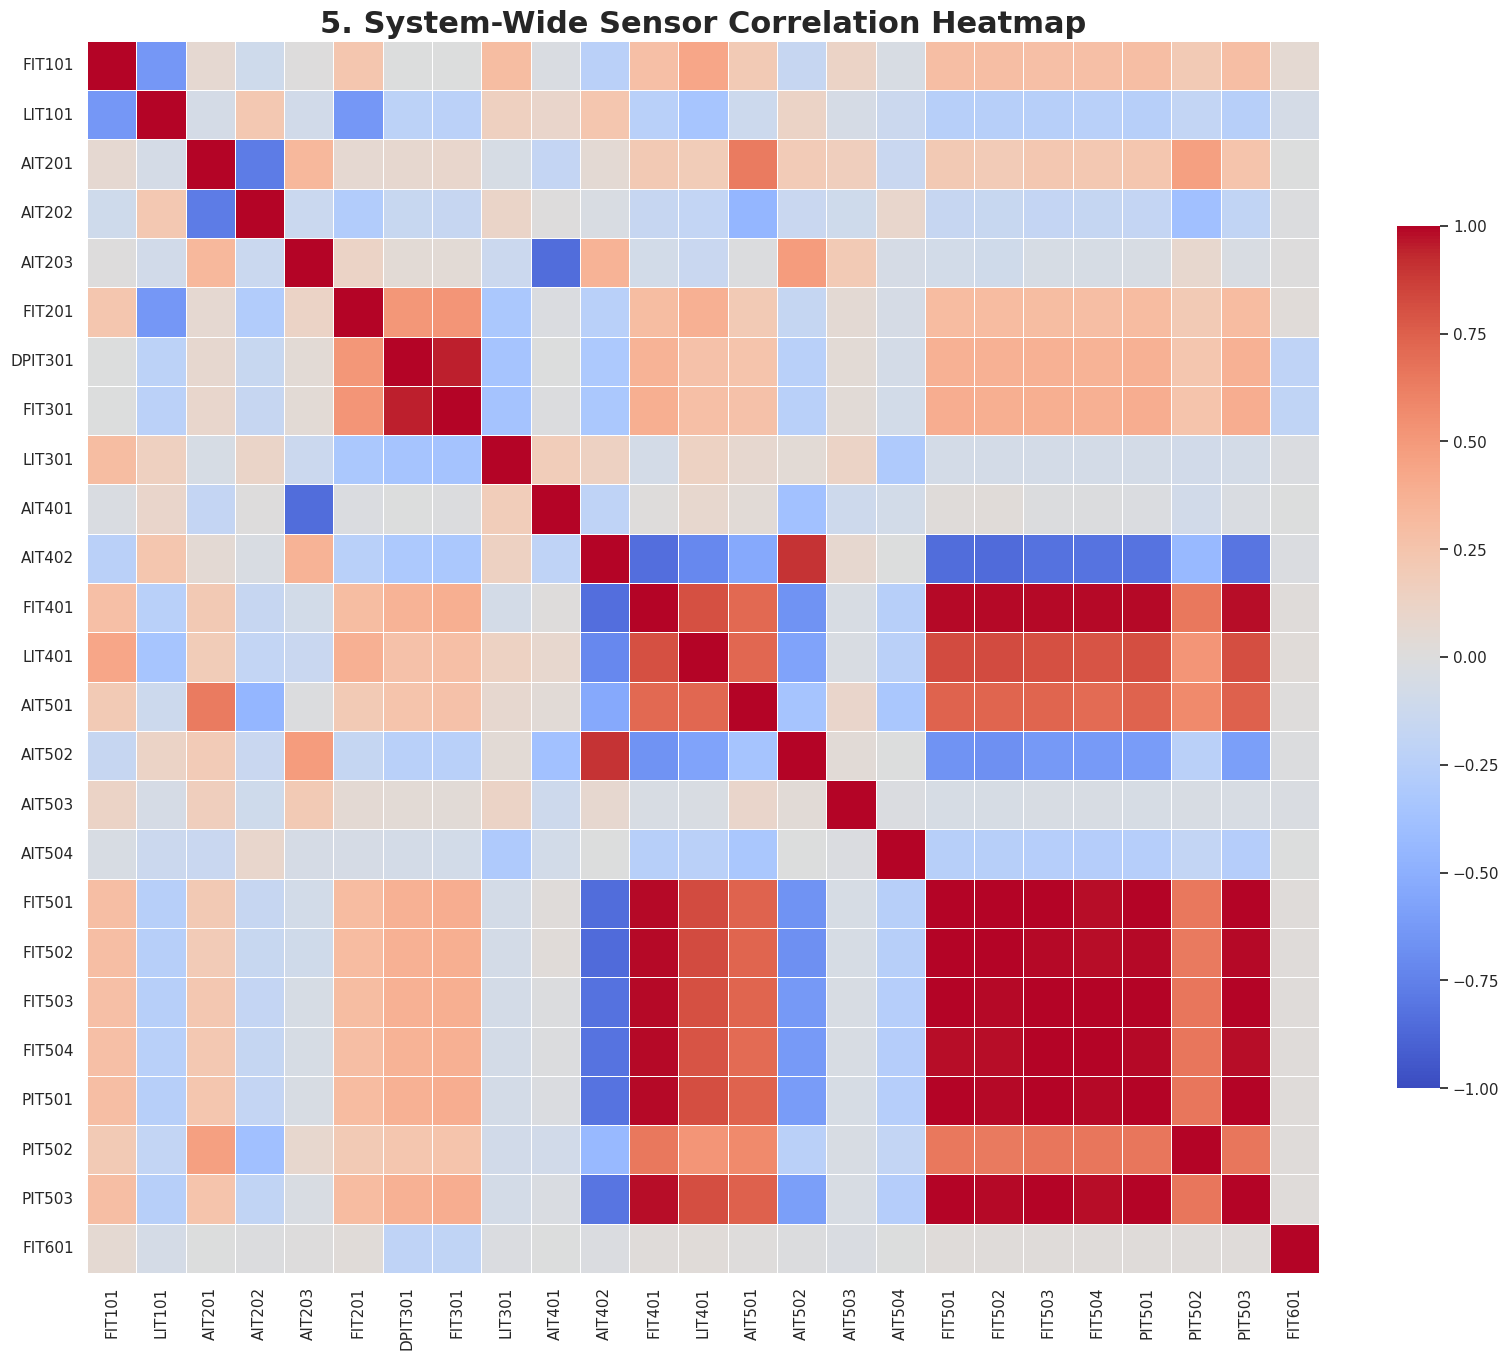

In [10]:
# Extract columns containing continuous sensory data (ignoring discrete actuators)
continuous_cols = [col for col in df.columns if any(x in col for x in ['FIT', 'LIT', 'AIT', 'PIT', 'DPIT'])]

plt.figure(figsize=(20, 16))
# Calculate Pearson correlation matrix
corr_matrix = df[continuous_cols].corr()

# Plot the heatmap with a diverging color map
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

plt.title('5. System-Wide Sensor Correlation Heatmap', fontsize=22, fontweight='bold')
plt.show()

## Time-Series Anomaly Scanner (Attack Signatures)

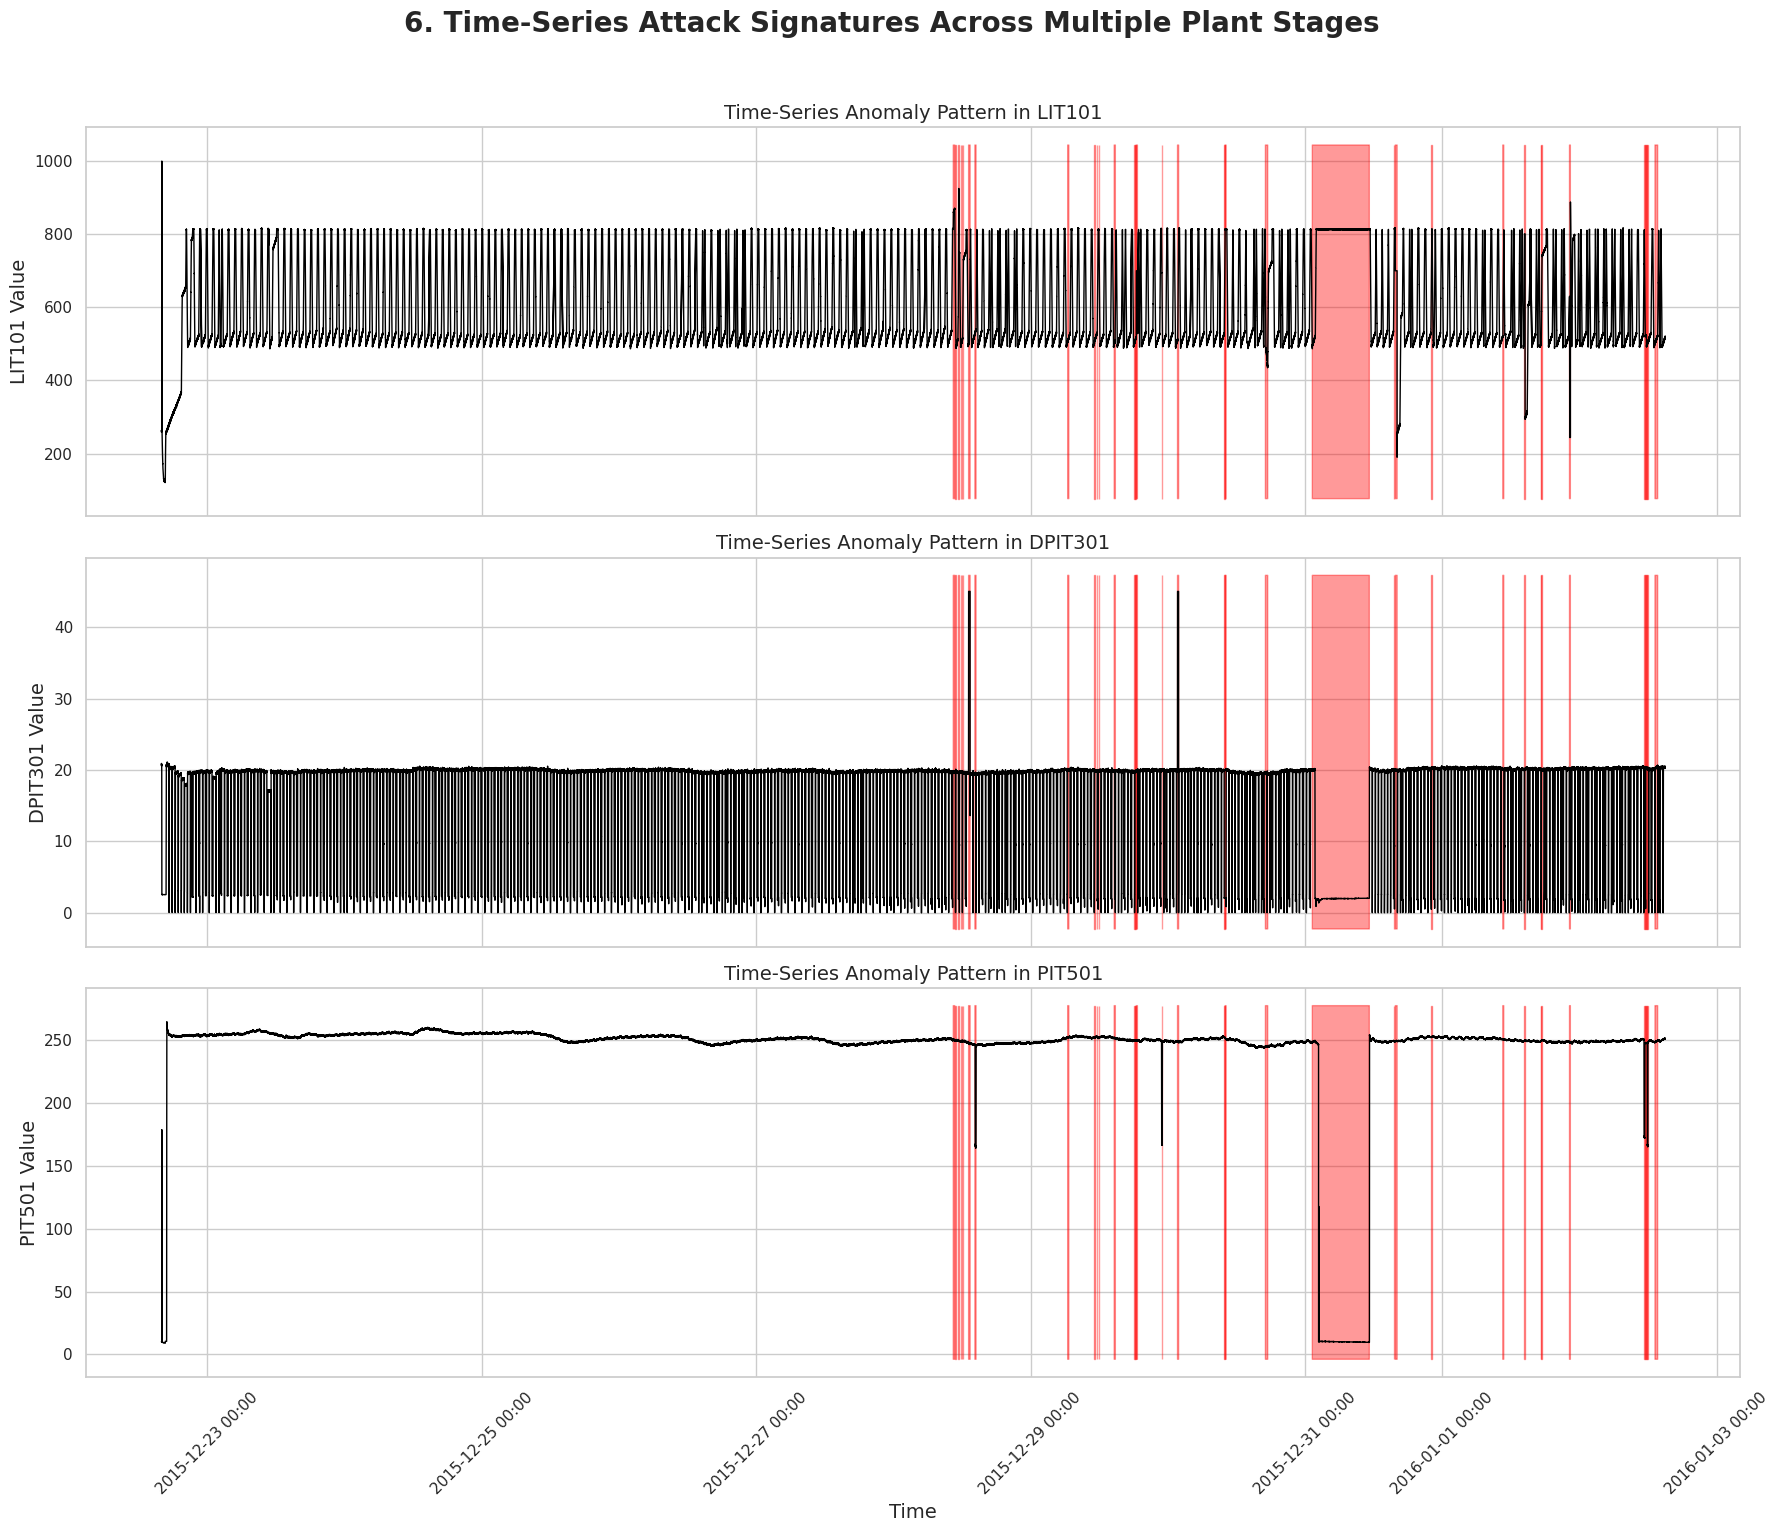

In [11]:
# Select key sensors from Stage 1, Stage 3, and Stage 5
sensors_to_scan = ['LIT101', 'DPIT301', 'PIT501']
fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)

for i, sensor in enumerate(sensors_to_scan):
    # Plot the time-series data for the sensor
    axes[i].plot(df['Timestamp'], df[sensor], color='black', linewidth=1)

    # Shade the background red during attack windows
    axes[i].fill_between(df['Timestamp'], axes[i].get_ylim()[0], axes[i].get_ylim()[1],
                         where=(df['label']==1), color='red', alpha=0.4)

    axes[i].set_ylabel(f'{sensor} Value')
    axes[i].set_title(f'Time-Series Anomaly Pattern in {sensor}', fontsize=14)

# Format the X-axis for better readability of dates and times
axes[-1].set_xlabel('Time')
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.suptitle('6. Time-Series Attack Signatures Across Multiple Plant Stages', y=1.02, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()